In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
%matplotlib inline

In [4]:
from rsnn.spike_train.sampler import sample_spike_trains
from rsnn.spike_train.utils import check_refractoriness

# Utils sampler

In [18]:
def hyperball_sampling(dim, radius, num_samples=None):
    if num_samples is None:
        z = np.random.normal(size=(dim+2))
        return z[:-2]*radius / np.sqrt(np.sum(np.square(z)))
    
    z = np.random.normal(size=(num_samples, dim+2))
    return z[:, :-2]*radius / np.sqrt(np.sum(np.square(z), axis=1, keepdims=True))
    
def simplex_sampling(breve_s, tmin, tmax, num_samples=None):
    n = breve_s.size
    duration = tmax - tmin
    if num_samples is None:
        u = np.sort(np.random.uniform(0, duration-(n-1), n)) + np.arange(n)
        return np.sort((u - tmin) % duration + tmin)
    
    u = np.sort(np.random.uniform(0, duration-(n-1), (num_samples, n)), axis=1) + np.arange(n)[None,:]
    return np.sort((u - tmin) % duration + tmin, axis=1)

In [19]:
samples = hyperball_sampling(2, 2, 10000)

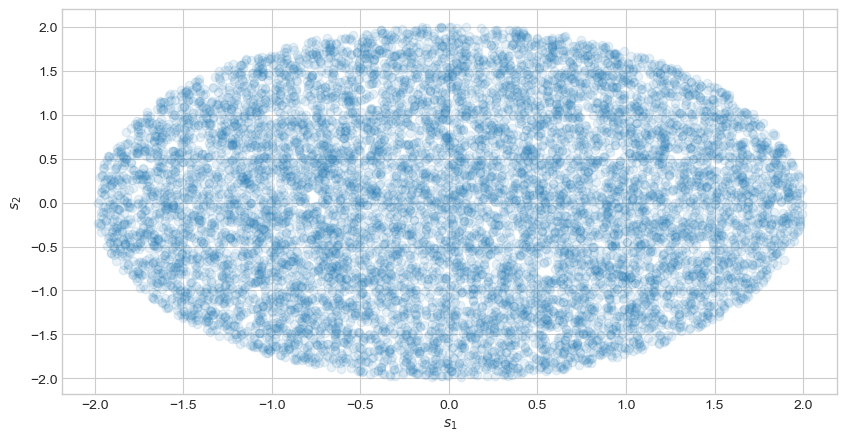

In [20]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
#ax.view_init(45, 30, 0)

ax.scatter(samples[:,0], samples[:,1], alpha=0.1)

ax.set_xlabel("$s_1$")
ax.set_ylabel("$s_2$")

plt.show()

In [21]:
samples = simplex_sampling(np.array([1.3, 4.5]), 0, 6, 10000)

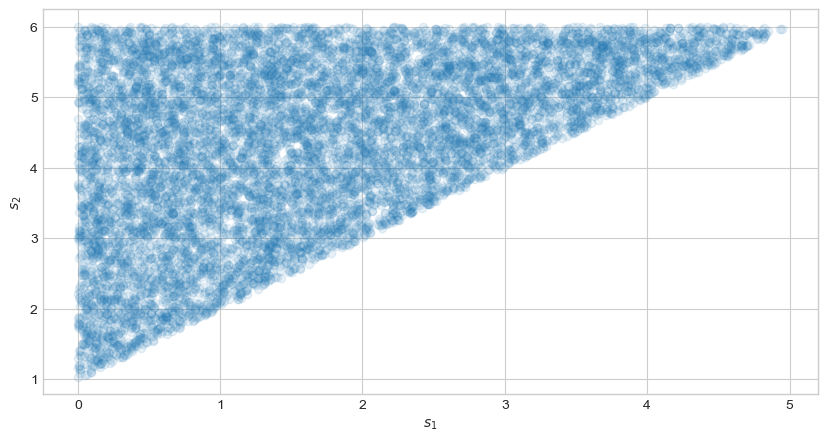

In [22]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
#ax.view_init(45, 30, 0)

ax.scatter(samples[:,0], samples[:,1], alpha=0.1)

ax.set_xlabel("$s_1$")
ax.set_ylabel("$s_2$")

plt.show()

## Accept/Reject Sampling for Jittered Spike Trains

The rejection probability increases exponentially with $\sigma$.

In [5]:
num_neurons = 10000
period, firing_rate = 100, 0.2
spike_trains = sample_spike_trains(period, firing_rate, num_neurons)

sigmas = np.linspace(0,1,20)

In [6]:
num_rejections = []
for sigma in sigmas:
    num_rejections.append(0)
    jitter_dist = lambda size: np.random.normal(0, sigma, size)
    for firing_times in spike_trains:
        while True:
            tmp_firing_times = firing_times + jitter_dist(firing_times.size)
            if np.all(tmp_firing_times >= 0) and np.all(tmp_firing_times < period) and check_refractoriness(tmp_firing_times):
                break
            num_rejections[-1] += 1/num_neurons

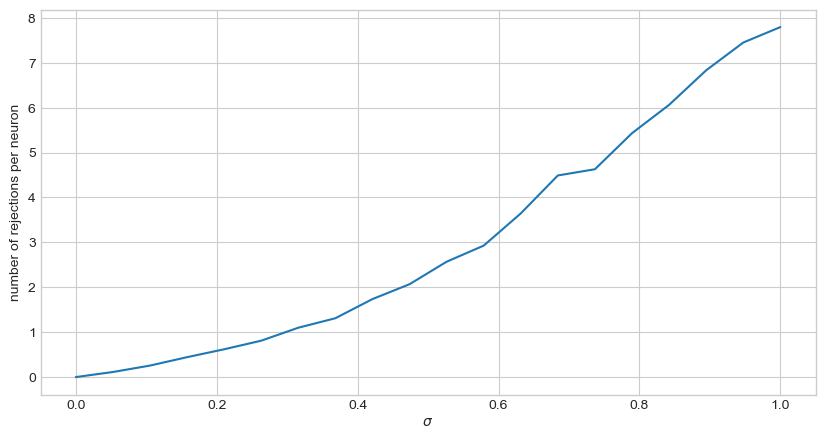

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
    
ax.plot(sigmas, num_rejections)

ax.set_xlabel("$\sigma$")
ax.set_ylabel("number of rejections per neuron")

plt.show()

The rejection probability should increase exponentially with the period

In [8]:
num_neurons = 10000
firing_rate = 0.2

sigma = 0.2
jitter_dist = lambda size: np.random.normal(0, sigma, size)

In [9]:
periods = np.linspace(50,500,20)

num_rejections = []
for period in periods:
    spike_trains = sample_spike_trains(period, firing_rate, num_neurons)

    num_rejections.append(0)
    
    for firing_times in spike_trains:
        while True:
            tmp_firing_times = firing_times + jitter_dist(firing_times.size)
            if np.all(tmp_firing_times >= 0) and np.all(tmp_firing_times < period) and check_refractoriness(tmp_firing_times):
                break
            num_rejections[-1] += 1/num_neurons

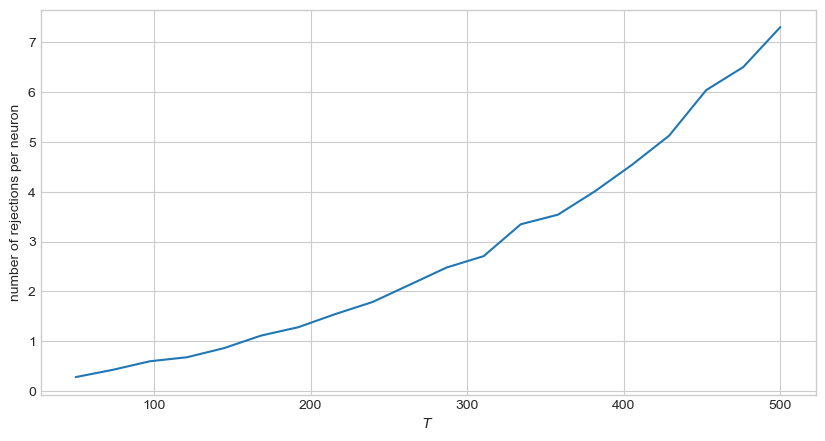

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
    
ax.plot(periods, num_rejections)

ax.set_xlabel("$T$")
ax.set_ylabel("number of rejections per neuron")

plt.show()

# Gibbs Sampling

In [67]:
from scipy.stats import truncnorm

In [351]:
n = 11
odd_indices = np.arange(1, n-1, 2)
even_indices = np.arange(2, n-1, 2)
odd_indices, even_indices

(array([1, 3, 5, 7, 9]), array([2, 4, 6, 8]))

In [418]:
rng = np.random.default_rng()

In [428]:
truncnorm.rvs(0, 1, random_state=rng)

0.7467806653460836

In [410]:
def gibbs_sampling(breve_s, sigma, tmin=None, tmax=None, niter=1000, s0=None):
    n = breve_s.size

    n_is_odd = bool(n%2)

    odd_indices = np.arange(1, n-1, 2)
    even_indices = np.arange(2, n-1, 2)

    if s0 is None:
        prev_s = np.copy(breve_s)
    else:
        prev_s = s0
    
    s = np.empty_like(prev_s)

    if tmin is None:
        tmin = -np.inf
    if tmax is None:
        tmax = np.inf

    sampler = lambda a_, b_, loc_: truncnorm.rvs((a_ - loc_)/sigma, (b_ - loc_)/sigma, loc=loc_, scale=sigma)
    
    for i in range(niter):
        # fix even indices and sample odd ones
        s[odd_indices] = sampler(prev_s[odd_indices-1] + 1, prev_s[odd_indices+1] - 1, breve_s[odd_indices])
        if not n_is_odd:
            s[-1] = sampler(prev_s[-2] + 1, tmax, breve_s[-1])
        
        # fix odd indices and sample the even ones
        s[0] = sampler(tmin, s[1] - 1, breve_s[0])
        if n_is_odd:
            s[-1] = sampler(s[-2] + 1, tmax, breve_s[-1])
        s[even_indices] = sampler(s[even_indices-1] + 1, s[even_indices+1] - 1, breve_s[even_indices])

        prev_s = np.copy(s)
        
    return prev_s

In [412]:
#breve_s = np.array([0.3, 1.4, 5.7, 8.9])
#breve_s = np.array([0.3, 1.4])
breve_s = np.array([0.3, 1.4, 13.4, 15.6, 22.5])

period = 25

sigma = 10
gibbs_sampling(breve_s, sigma, 0, 10, niter=5000, s0=np.array([0.3, 1.4, 2.5, 3.6, 4.7]))

array([0.31844892, 1.94137188, 5.01517955, 7.08633317, 9.88437342])

In [413]:
def gibbs_sampling_hist(breve_s, sigma, tmin=None, tmax=None, niter=1000, s0=None):
    n = breve_s.size

    n_is_odd = bool(n%2)

    odd_indices = np.arange(1, n-1, 2)
    even_indices = np.arange(2, n-1, 2)

    if s0 is None:
        prev_s = np.copy(breve_s)
    else:
        prev_s = s0
    
    s = np.empty_like(prev_s)
    hist_s = [prev_s]
    
    if tmin is None:
        tmin = -np.inf
    if tmax is None:
        tmax = np.inf

    sampler = lambda a_, b_, loc_: truncnorm.rvs((a_ - loc_)/sigma, (b_ - loc_)/sigma, loc=loc_, scale=sigma)
    
    for i in range(niter):
        # fix even indices and sample odd ones
        s[odd_indices] = sampler(prev_s[odd_indices-1] + 1, prev_s[odd_indices+1] - 1, breve_s[odd_indices])
        if not n_is_odd:
            s[-1] = sampler(prev_s[-2] + 1, tmax, breve_s[-1])
        
        # fix odd indices and sample the even ones
        s[0] = sampler(tmin, s[1] - 1, breve_s[0])
        if n_is_odd:
            s[-1] = sampler(s[-2] + 1, tmax, breve_s[-1])
        s[even_indices] = sampler(s[even_indices-1] + 1, s[even_indices+1] - 1, breve_s[even_indices])

        prev_s = np.copy(s)
        hist_s.append(prev_s)
        
    return np.stack(hist_s)

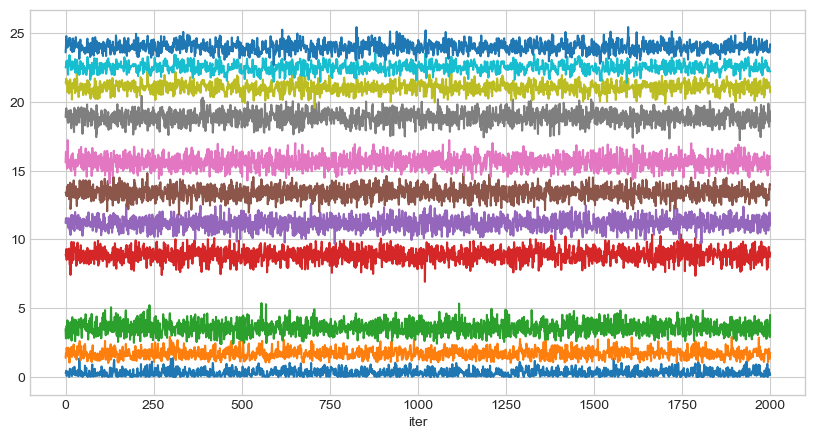

In [436]:
breve_s = np.array([0.3, 1.4, 3.5, 8.9, 11.2, 13.4, 15.6, 18.9, 21.4, 22.5, 23.6])
hist_s = gibbs_sampling_hist(breve_s, 0.5, 0, None, 2000)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

for i in range(breve_s.size):
    ax.plot(np.arange(hist_s.shape[0]), hist_s[:,i])

ax.set_xlabel("iter")

plt.show()

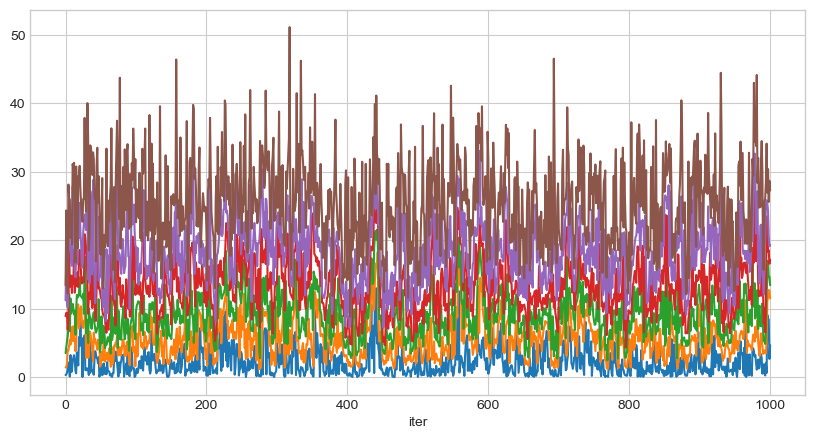

In [415]:
breve_s = np.array([0.3, 1.4, 3.5, 8.9, 11.2, 13.4])
hist_s = gibbs_sampling_hist(breve_s, 10, 0, None, 1000)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

for i in range(breve_s.size):
    ax.plot(np.arange(hist_s.shape[0]), hist_s[:,i])

ax.set_xlabel("iter")

plt.show()

In [417]:
breve_s = np.array([0.3, 1.4, 3.5, 8.9, 11.2, 13.4])

hist_s = gibbs_sampling_hist(breve_s, sigma, 0, 10, niter=1000, s0=np.array([0.0, 1.1, 2.2, 3.3, 4.4, 5.5]))
#hist_s = gibbs_sampling_hist(breve_s, sigma, 0, 10, niter=1000) -> error domain for truncated normal

fig, ax = plt.subplots(1, 1, figsize=(10,5))

for i in range(breve_s.size):
    ax.plot(np.arange(hist_s.shape[0]), hist_s[:,i])

ax.set_xlabel("iter")

plt.show()

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.truncnorm` documentation for details.

# Metropolis-Hastings

In [29]:
def metropolis_hastings(breve_s, tmin, tmax, s2, niter=1000):
    n = breve_s.size
    prev_s = np.copy(breve_s)
    s = simplex_sampling(breve_s, 0, tmax - tmin, num_samples=niter)
    
    for i in range(niter):        
        # accept the candidate with some acceptance probability
        if np.random.rand() < np.clip(np.exp(-np.sum((s[i] - prev_s)*(s[i] + prev_s - 2*breve_s)/(2*s2))), None, 1):
            prev_s = s[i]
            
    return prev_s + tmin

In [42]:
#breve_s = np.array([0.3, 1.4, 5.7, 8.9])
breve_s = np.array([0.3, 1.4])
period = 3

s2 = 0.01
metropolis_hastings(breve_s, 0, 5, s2, niter=1000)

array([0.02616616, 1.4819133 ])

In [194]:
breve_s = np.array([0.3, 1.4, 3.5, 8.9, 11.2, 13.4, 15.6, 18.9, 21.4, 22.5, 23.6])
tmin, tmax = 0, 10
sigma = 1

niter = 5000
n = breve_s.size

s = simplex_sampling(breve_s, 0, tmax - tmin, num_samples=niter)

prev_s = np.copy(s[0])
hist_s = [prev_s]

for i in range(1, niter):        
    # accept the candidate with some acceptance probability
    if np.random.rand() < np.clip(np.exp(np.sum(np.square(prev_s - breve_s) - np.square(s[i] - breve_s))/(2*sigma**2)), None, 1):
        prev_s = s[i]
    hist_s.append(prev_s)

hist_s = np.stack(hist_s)

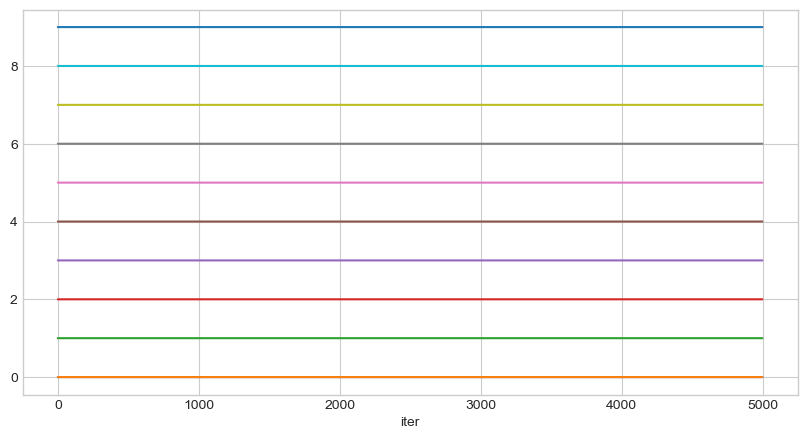

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

for i in range(n):
    ax.plot(np.arange(niter), hist_s[:,i])

ax.set_xlabel("iter")

plt.show()

In [55]:
breve_s = np.array([0.3, 1.4])
tmin, tmax = 0, 10
s2 = 0.1

num_samples = 5000
samples = []

for _ in range(num_samples):
    samples.append(metropolis_hastings(breve_s, tmin, tmax, s2, niter=1000))

samples = np.stack(samples)

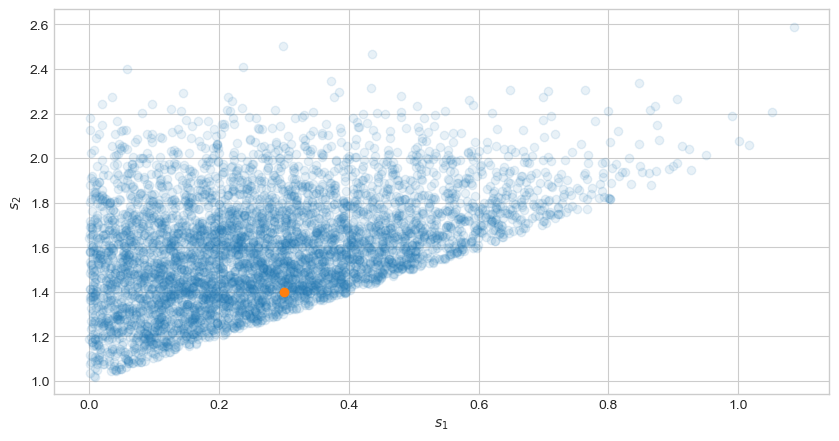

In [56]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
#ax.view_init(45, 30, 0)

ax.scatter(samples[:,0], samples[:,1], alpha=0.1)
ax.scatter(breve_s[0], breve_s[1])

ax.set_xlabel("$s_1$")
ax.set_ylabel("$s_2$")

plt.show()

# Slice Sampling

In [382]:
def slice_sampling(breve_s, sigma, tmin, tmax=None, niter=100):
    n = breve_s.size
    prev_s = breve_s
        
    if tmax is None:
        duration = np.inf
        r_thresh = np.inf
    else:
        duration = tmax - tmin
        vertices = np.tile(np.arange(n), (n+1, 1))*(1 - np.triu(np.ones((n+1,n)))) + np.tile(duration - np.arange(n-1,-1,-1), (n+1, 1))*np.triu(np.ones((n+1,n)))
        # the radius of the smallest ball containing the simplex
        r_thresh = np.sqrt(np.max(np.sum(np.square(vertices - breve_s), axis=1)))
    
    for _ in range(niter):
        # sample y
        y = np.random.uniform(0, np.exp(-np.sum(np.square(prev_s - breve_s))/(2*sigma**2)))
        r = sigma*np.sqrt(-2 * np.log(y))
        
        # sample uniformly a candidate over intersection between the hyperball of radius r centered at breve_s and the simplex
        if r < r_thresh:
            for _ in range(10000):
                s = hyperball_sampling(n, r) + breve_s
                if np.all(s >= 0) and np.all(s < duration) and np.all(np.sort(s) == s) and check_refractoriness(s):
                    prev_s = s
                    break
        else:
            prev_s = simplex_sampling(breve_s, 0, duration)
            
    return prev_s + tmin

In [383]:
#breve_s = np.array([0.3, 1.4, 5.7, 8.9])
#breve_s = np.array([0.3, 1.4])
breve_s = np.array([0.3, 1.4, 3.5, 8.9, 11.2, 13.4, 15.6, 18.9, 21.4, 22.5, 23.6])

period = 25

sigma = 1
slice_sampling(breve_s, sigma, 0, None, niter=2000)

array([ 0.47393063,  1.95243107,  3.81809344,  6.87694019, 11.13153023,
       15.01231715, 16.0660882 , 18.50615834, 19.77238275, 21.38349592,
       25.15402828])

In [384]:
def slice_sampling_hist(breve_s, sigma, tmin, tmax=None, niter=100):
    n = breve_s.size
    prev_s = breve_s
    hist_s = [prev_s]
        
    if tmax is None:
        duration = np.inf
        r_thresh = np.inf
    else:
        duration = tmax - tmin
        vertices = np.tile(np.arange(n), (n+1, 1))*(1 - np.triu(np.ones((n+1,n)))) + np.tile(duration - np.arange(n-1,-1,-1), (n+1, 1))*np.triu(np.ones((n+1,n)))
        # the radius of the smallest ball containing the simplex
        r_thresh = np.sqrt(np.max(np.sum(np.square(vertices - breve_s), axis=1)))
    
    for _ in range(1,niter):
        # sample y
        y = np.random.uniform(0, np.exp(-np.sum(np.square(prev_s - breve_s))/(2*sigma**2)))
        r = sigma*np.sqrt(-2 * np.log(y))
        
        # sample uniformly a candidate over intersection between the hyperball of radius r centered at breve_s and the simplex
        if r < r_thresh:
            for _ in range(10000):
                s = hyperball_sampling(n, r) + breve_s
                if np.all(s >= 0) and np.all(s < duration) and np.all(np.sort(s) == s) and check_refractoriness(s):
                    prev_s = s
                    break
        else:
            prev_s = simplex_sampling(breve_s, 0, duration)

        hist_s.append(prev_s)
            
    return np.stack(hist_s)

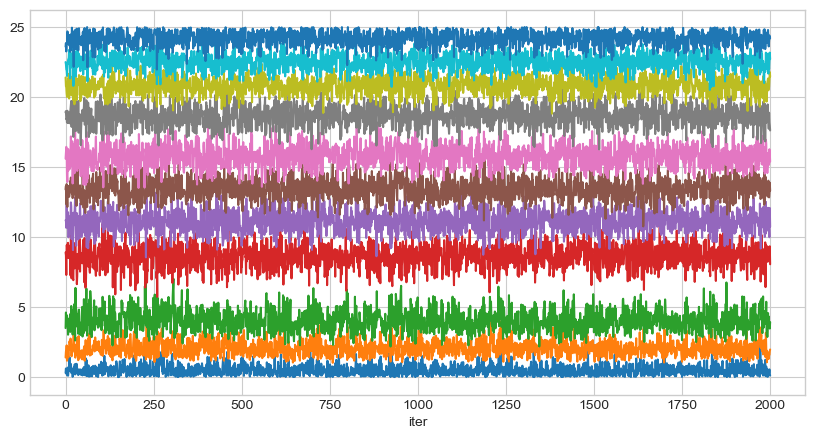

In [429]:
breve_s = np.array([0.3, 1.4, 3.5, 8.9, 11.2, 13.4, 15.6, 18.9, 21.4, 22.5, 23.6])
hist_s = slice_sampling_hist(breve_s, 1, 0, 25, 2000)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

for i in range(breve_s.size):
    ax.plot(np.arange(hist_s.shape[0]), hist_s[:,i])

ax.set_xlabel("iter")

plt.show()

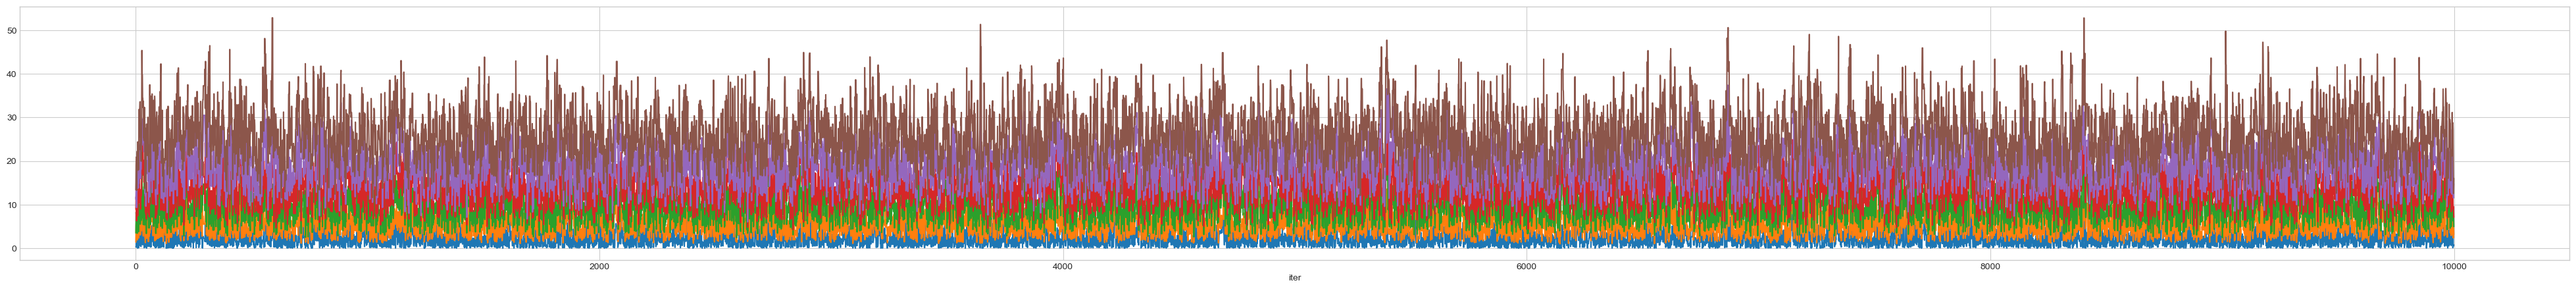

In [386]:
breve_s = np.array([0.3, 1.4, 3.5, 8.9, 11.2, 13.4])
hist_s = slice_sampling_hist(breve_s, 10, 0, None, 10000)

fig, ax = plt.subplots(1, 1, figsize=(50,5))

for i in range(breve_s.size):
    ax.plot(np.arange(hist_s.shape[0]), hist_s[:,i])

ax.set_xlabel("iter")

plt.show()